In [249]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_log_error as RMSLE
from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit


rmsle_scorer = make_scorer(RMSLE, greater_is_better=False)

In [250]:
train = pd.read_csv('../../data/processed_data/merged_train.csv')
test = pd.read_csv('../../data/processed_data/merged_test.csv')

# Fill NaN holiday names with 'None' for consistent string data type along columns
train[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']] = train[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']].fillna(value='None')
test[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']] = test[['hol_Nat_name','hol_Reg_name','hol_loc_name','hol_event_name']].fillna(value='None')


In [251]:
# Distinguish categorical variables for XGBoost

# categorical: dates, store identifiers, locations, holidays, and product families
# non-categorical: transactions, oil, onpromotion
# target variable: sales

cat_attribs = ['date', 'year', 'month', 'week_number', 'day', 'day_of_week',
       'store_nbr', 'type', 'cluster', 'city', 'state',
       'hol_Nat', 'hol_Nat_name', 'hol_Reg', 'hol_Reg_name', 'hol_Loc',
       'hol_loc_name', 'event', 'hol_event_name', 'transferred',
       'hol_type_Additional', 'hol_type_Bridge', 'hol_type_Event',
       'hol_type_Holiday', 'hol_type_Transfer', 'hol_type_Work Day', 'family']

# Split data by store and product families

In [318]:
# Create lists of store numbers and product families
stores = range(1,55)
families = list(train.family.unique())

# Create dictionaries to store data by store number and family
train_data = {}
test_data = {}

# Group data by store and family
train_grouped = train.groupby(['store_nbr', 'family'])
test_grouped = test.groupby(['store_nbr','family'])

# Create the nested dictionaries
# e.g. train_data[1]['AUTOMOTIVE'] for rows from store 1 automotive sales
train_data = {
    store: {
        family: train_grouped.get_group((store, family)) 
        for family in families if (store, family) in train_grouped.groups
    }
    for store in stores
}

test_data = {
    store: {
        family: test_grouped.get_group((store, family)) 
        for family in families if (store, family) in test_grouped.groups
    }
    for store in stores
}

# XGBoost on an single store/family (to test hyperparameter tuning)

In [253]:
# Choose your store number and family
single_store = 48
single_family = 'PRODUCE'


# ------------------------------------------------------------------------------------
# Create training and validation sets

# Grabs the training data, add lag 1, lag 7, and rolling avg features
X = train_data[single_store][single_family]
X['lag_1'] = X['sales'].shift(1)    # Daily lag
X['lag_7'] = X['sales'].shift(7)    # Weekly lag
X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
# Drop rows with NaNs created by shifts
X = X.dropna()


# Split data into X and y
X_train = X.drop(columns=['transactions','sales'])
y_train = X[['year','month','sales']]

# Define training sets from Jan 1, 2013 to Aug 1, 2017
X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])
y_tt_log = np.log1p(y_tt)

# Define validation sets with Aug 1-15, 2017 data
X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])
y_val_log = np.log1p(y_val)

# Cast categorical variables as 'category' type for XGBoost.
X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
X_val[cat_attribs] = X_val[cat_attribs].astype('category')

# ------------------------------------------------------------------------------------
# Hyperparameter tuning using grid search

# Create model
model = xgb.XGBRegressor(enable_categorical=True)

# Define Parameter Grid
param_grid = {
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [10, 25, 50, 100,200],
    #'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
}

# Grid Search
grid_search = GridSearchCV(estimator=model, 
                           param_grid=param_grid, 
                           scoring=rmsle_scorer, 
                           cv=TimeSeriesSplit(n_splits=5), 
                           verbose=1,
                           n_jobs=-1)
# Fit to training data
grid_search.fit(X_tt, y_tt_log)


# Best parameters and RMSLE
print("Best Parameters:", grid_search.best_params_)
print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters: {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100}
Lowest RMSLE: 0.455459859636806


# Hyperparameter tuning on one store of each type, all families

In [274]:
best_params = {'A':[],'B':[],'C':[],'D':[],'E':[]}

In [275]:
# Choose your store number 
single_store = 49

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params['A'].append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.49850748561915664
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: -0.0
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Lowest RMSLE: 0.5072837439372132
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Lowest RMSLE: 0.30771075886221844
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_e

In [276]:
# Choose your store number 
single_store = 21

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params['B'].append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 25}
Lowest RMSLE: 0.4902410233918878
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.5230095387907134
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.5985394760695439
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 50}
Lowest RMSLE: 0.3382192365854605
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth

In [278]:
# Choose your store number 
single_store = 14

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params['C'].append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 10}
Lowest RMSLE: 0.6560499025001114
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 10}
Lowest RMSLE: 0.047047392202622586
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 25}
Lowest RMSLE: 0.7703350666146067
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 25}
Lowest RMSLE: 0.4180111833166609
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_dep

In [279]:
# Choose your store number 
single_store = 1

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params['D'].append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 25}
Lowest RMSLE: 0.6306831672357263
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: -0.0
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 25}
Lowest RMSLE: 0.5768664580406819
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Lowest RMSLE: 0.3717632949530067
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 6, 'n_esti

In [280]:
# Choose your store number 
single_store = 36

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params['E'].append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 10}
Lowest RMSLE: 0.5596129228517484
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 10}
Lowest RMSLE: 0.13912037375842237
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 25}
Lowest RMSLE: 0.6006326086771276
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.2873169061428828
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth

# Fined tuned parameters with quantiles (store 6)

In [255]:
# Choose your store number 
single_store = 6

# Save best parameters for each family
best_params_quantile = []

# ------------------------------------------------------------------------------------
# Create training and validation sets

for index, family in enumerate(families):
# ------------------------------------------------------------------------------------
# Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # ------------------------------------------------------------------------------------
    # Hyperparameter tuning using grid search

    # Create model
    model = xgb.XGBRegressor(objective="reg:quantileerror", quantile_alpha=0.75,
                            enable_categorical=True)

    # Define Parameter Grid
    param_grid = {
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'n_estimators': [10, 25, 50, 100,200],
        #'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.2, 0.4, 0.6, 1.0]
    }

    # Grid Search
    grid_search = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=rmsle_scorer, 
                            cv=TimeSeriesSplit(n_splits=5), 
                            verbose=1,
                            n_jobs=-1)
    # Fit to training data
    grid_search.fit(X_tt, y_tt)

    best_params_quantile.append({'index':index,'family':family, 'params':grid_search.best_params_})

    # Best parameters and RMSLE
    print(f"Best Parameters for {family}:", grid_search.best_params_)
    print("Lowest RMSLE:", -grid_search.best_score_)

Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for AUTOMOTIVE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.6605741424908391
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BABY CARE: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 10}
Lowest RMSLE: 0.039902180308816315
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEAUTY: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 10}
Lowest RMSLE: 0.5756310419678369
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BEVERAGES: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Lowest RMSLE: 0.34042823545914563
Fitting 5 folds for each of 320 candidates, totalling 1600 fits
Best Parameters for BOOKS: {'colsample_bytree': 0.2, 'learning_rate': 0.01, 'max_d

# XGBoost single store with tuned parameters

In [ ]:
# Parameters

# Choose your store number 
single_store = 48

single_store_data = train[ train['store_nbr']== single_store]

# Partial DataFrame we will use to store predictions.
results = single_store_data[ (single_store_data['year']==2017) & (single_store_data['month']>=8) ]
results = results[['id','date','store_nbr','family','sales']]


# Loop through product families
for index, family in enumerate(families):
    # ------------------------------------------------------------------------------------
    # Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # Make model and fit
    model = xgb.XGBRegressor(#objective = rmsle_objective,
                            colsample_by_tree = best_params[index]['params']['colsample_bytree'],
                             learning_rate = best_params[index]['params']['learning_rate'],
                             max_depth = best_params[index]['params']['max_depth'],
                             n_estimators = best_params[index]['params']['n_estimators'],
                             enable_categorical=True)
    model.fit(X_tt, y_tt)


    # Make predictions
    predictions = model.predict(X_val)
    predictions = np.clip(predictions, a_min=0, a_max=None)
    # Find list of id's for rows where we want to add a prediction. Then add them.
    indices_to_fill = results[ (results['store_nbr']==single_store) & (results['family']==family) ]['id'].index
    
    # Merge predictions to results dataframe along the id's
    results.loc[indices_to_fill, 'predictions'] = predictions


print('RMSLE:',RMSLE(results.sales,results.predictions))

RMSLE: 0.9181205380793956


In [257]:
# Parameters with quantiles

# Choose your store number 
single_store = 48

single_store_data = train[ train['store_nbr']== single_store]

# Partial DataFrame we will use to store predictions.
results = single_store_data[ (single_store_data['year']==2017) & (single_store_data['month']>=8) ]
results = results[['id','date','store_nbr','family','sales']]


# Loop through product families
for index, family in enumerate(families):
    # ------------------------------------------------------------------------------------
    # Create training and validation sets

    # Grabs the training data, add lag 1, lag 7, and rolling avg features
    X = train_data[single_store][family]
    X['lag_1'] = X['sales'].shift(1)    # Daily lag
    X['lag_7'] = X['sales'].shift(7)    # Weekly lag
    X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
    # Drop rows with NaNs created by shifts
    X = X.dropna()

    # Split data into X and y
    X_train = X.drop(columns=['transactions','sales'])
    y_train = X[['year','month','sales']]

    # Define training sets from Jan 1, 2013 to Aug 1, 2017
    X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
    y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])

    # Define validation sets with Aug 1-15, 2017 data
    X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
    y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])

    # Cast categorical variables as 'category' type for XGBoost.
    X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
    X_val[cat_attribs] = X_val[cat_attribs].astype('category')

    # Make model and fit
    model = xgb.XGBRegressor(#objective = rmsle_objective,
                            colsample_by_tree = best_params_quantile[index]['params']['colsample_bytree'],
                             learning_rate = best_params_quantile[index]['params']['learning_rate'],
                             max_depth = best_params_quantile[index]['params']['max_depth'],
                             n_estimators = best_params_quantile[index]['params']['n_estimators'],
                             enable_categorical=True)
    model.fit(X_tt, y_tt)


    # Make predictions
    predictions = model.predict(X_val)
    predictions = np.clip(predictions, a_min=0, a_max=None)
    # Find list of id's for rows where we want to add a prediction. Then add them.
    indices_to_fill = results[ (results['store_nbr']==single_store) & (results['family']==family) ]['id'].index
    
    # Merge predictions to results dataframe along the id's
    results.loc[indices_to_fill, 'predictions'] = predictions


print('RMSLE:',RMSLE(results.sales,results.predictions))

RMSLE: 0.9364532600880341


# XGBoost on single stores (all families)

In [311]:
store_number = []
store_performance = []
store_type = []
results_by_store= {}

for store in stores:
    single_store = store
    single_store_data = train[ train['store_nbr']== single_store]
    letter_type = single_store_data['type'].iloc[-1]

    # Partial DataFrame we will use to store predictions.
    results = single_store_data[ (single_store_data['year']==2017) & (single_store_data['month']>=8) ]
    results = results[['id','date','store_nbr','family','sales']]

    # Train XGBoost models on each store and product family

    for family in families:
        
        # Picks data from one store and family, split into X and y
        X = train_data[single_store][family]
        X['lag_1'] = X['sales'].shift(1)    # Daily lag
        X['lag_7'] = X['sales'].shift(7)    # Weekly lag
        X['rolling_avg_7'] = X['sales'].shift(1).rolling(window=7).mean()
        X = X.dropna()                      # Drop rows with NaNs created by shifts
        
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['year','month','sales']]

        # Training sets up to Aug 2017
        X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
        y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])
        # Validation sets from Aug 1-15, 2017
        X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
        y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])
        
        # Cast categorical variables for XGBoost.
        X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
        X_val[cat_attribs] = X_val[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(colsample_by_tree = best_params[letter_type][index]['params']['colsample_bytree'],
                            learning_rate = best_params[letter_type][index]['params']['learning_rate'],
                            max_depth = best_params[letter_type][index]['params']['max_depth'],
                            n_estimators = best_params[letter_type][index]['params']['n_estimators'],
                            enable_categorical=True)
        model.fit(X_tt, y_tt)

        # Make predictions
        predictions = model.predict(X_val)
        #predictions = np.clip(predictions, a_min=0, a_max=None)
        predictions[predictions<1] = 0
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = results[ (results['store_nbr']==single_store) & (results['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        results.loc[indices_to_fill, 'predictions'] = predictions
        
        results_by_store[store] = results

    store_number.append(store)
    store_type.append(single_store_data['type'].iloc[-1])
    store_performance.append(RMSLE(results.sales,results.predictions))

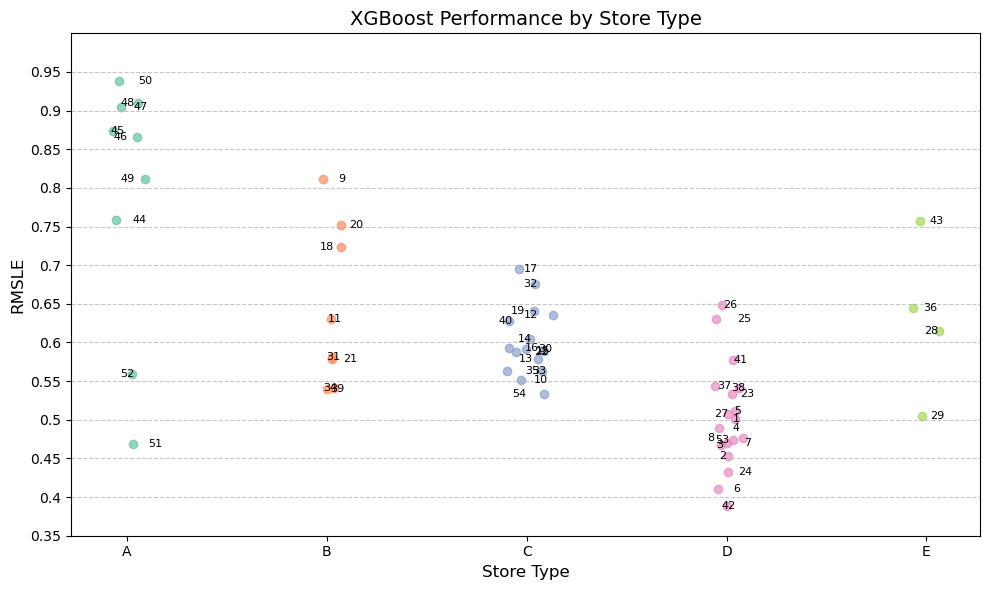

In [313]:
# Define the unique store types for the x-axis and assign numeric positions
store_types_unique = ['A', 'B', 'C', 'D', 'E']
x_positions = {store: i + 1 for i, store in enumerate(store_types_unique)}

# Define colors for each store type
colors = sns.color_palette("Set2", len(store_types_unique))
type_color_map = {store: colors[i] for i, store in enumerate(store_types_unique)}

# Create the plot
plt.figure(figsize=(10, 6))

# Plot each store with label
for i in range(len(store_number)):
    x = x_positions[store_type[i]]
    y = store_performance[i]
    plt.scatter(x+0.05*np.random.randn(), y, color=type_color_map[store_type[i]], alpha=0.7)
    plt.text(x+0.05*np.random.randn(), y, str(store_number[i]), fontsize=8, va='center', ha='left')

# Customizing the plot
plt.xlabel("Store Type", fontsize=12)
plt.ylabel("RMSLE", fontsize=12)
plt.title("XGBoost Performance by Store Type", fontsize=14)

plt.xticks(ticks=list(x_positions.values()), labels=store_types_unique)
plt.ylim(0.35, 1)
plt.yticks(ticks=[i for i in np.arange(0.35, 1, 0.05)], labels=[round(i,2) for i in np.arange(0.35, 1, 0.05)])

plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


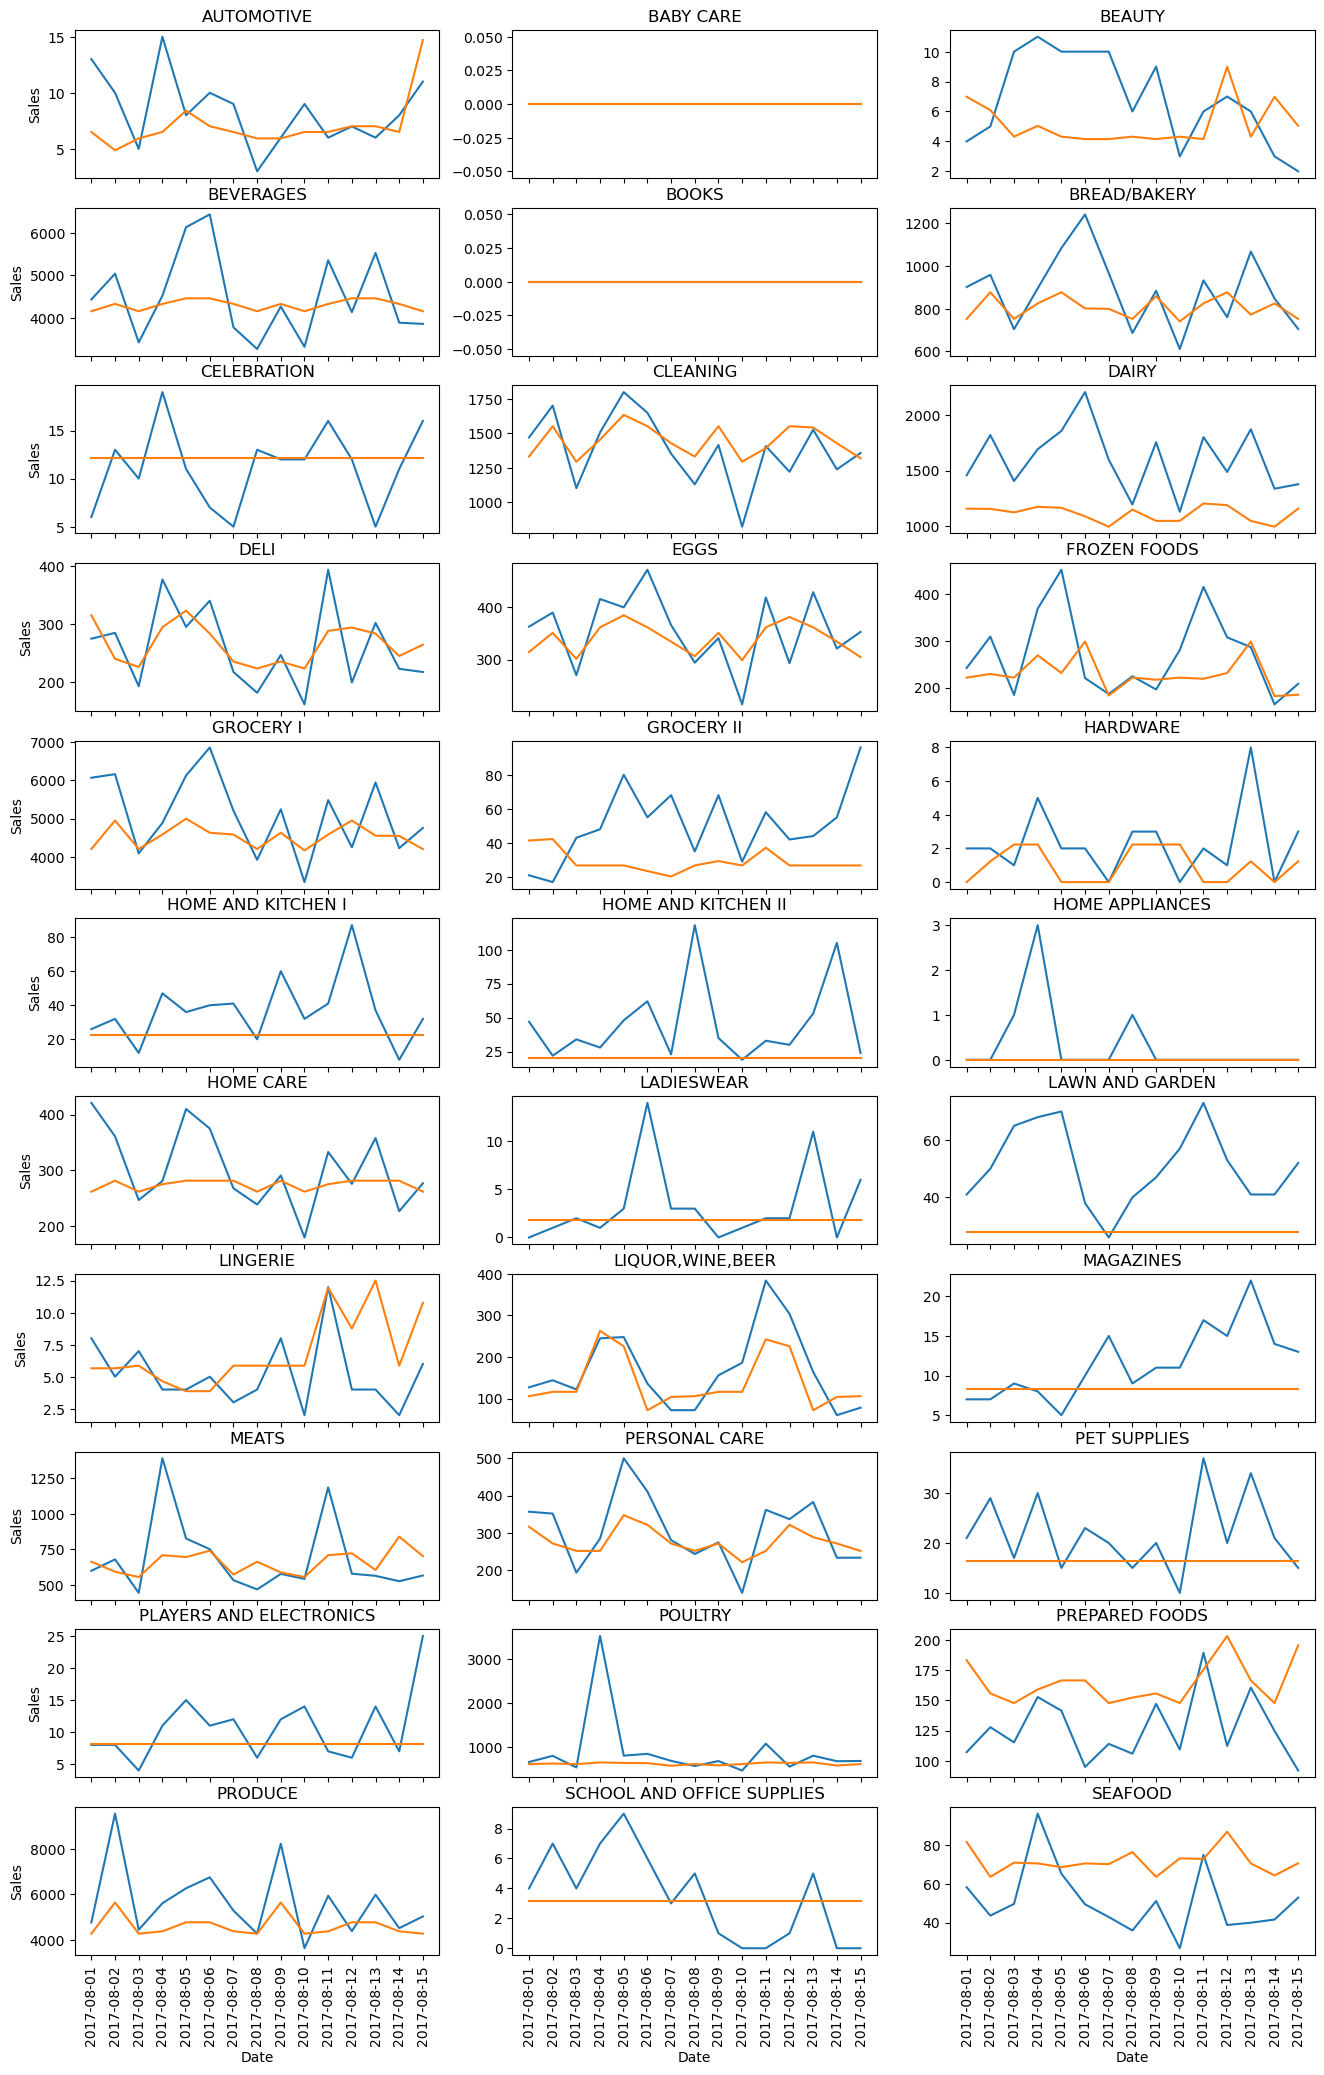

In [300]:
# Pick store to plot
single_store = 51

# Plot total sales and predicted sales
dates = pd.Series(pd.date_range(start='8/1/2017', end='8/15/2017',freq='D')).astype('str')

fig,ax = plt.subplots(nrows=11,ncols=3,figsize=(16,25),sharex=True)

for index,family in enumerate(families):
    # index//3 gives axis row number to plot
    # index%3 gives axis column number to plot
    ax[index//3,index%3].set_title(f'{family}')
    
    y= results_by_store[single_store]
    
    if (index//3)==10:
        ax[index//3,index%3].set_xlabel('Date')
        ax[index//3,index%3].set_xticks(ticks=dates,labels=dates, rotation=90)
    if (index%3)==0:
        ax[index//3,index%3].set_ylabel('Sales')
    
    ax[index//3,index%3].plot(dates, y[ y['family']==family ].sales.values)
    ax[index//3,index%3].plot(dates, y[ y['family']==family ].predictions.values)

plt.show()


In [340]:
tuned_combined = results_by_store[1]
for i in range(2,55):
    tuned_combined = pd.concat([tuned_combined,results_by_store[i]])
tuned_combined

,id,date,store_nbr,family,sales,predictions
2728374,2974158,2017-08-01,1,AUTOMOTIVE,5.000,3.087248
2728375,2974159,2017-08-01,1,BABY CARE,0.000,0.000000
2728376,2974160,2017-08-01,1,BEAUTY,4.000,2.176029
2728377,2974161,2017-08-01,1,BEVERAGES,2627.000,1681.972046
2728378,2974162,2017-08-01,1,BOOKS,0.000,0.000000
...,...,...,...,...,...,...
2754967,3000751,2017-08-15,54,POULTRY,59.619,50.390835
2754968,3000752,2017-08-15,54,PREPARED FOODS,94.000,60.837444
2754969,3000753,2017-08-15,54,PRODUCE,915.371,365.958466
2754970,3000754,2017-08-15,54,SCHOOL AND OFFICE SUPPLIES,0.000,0.000000


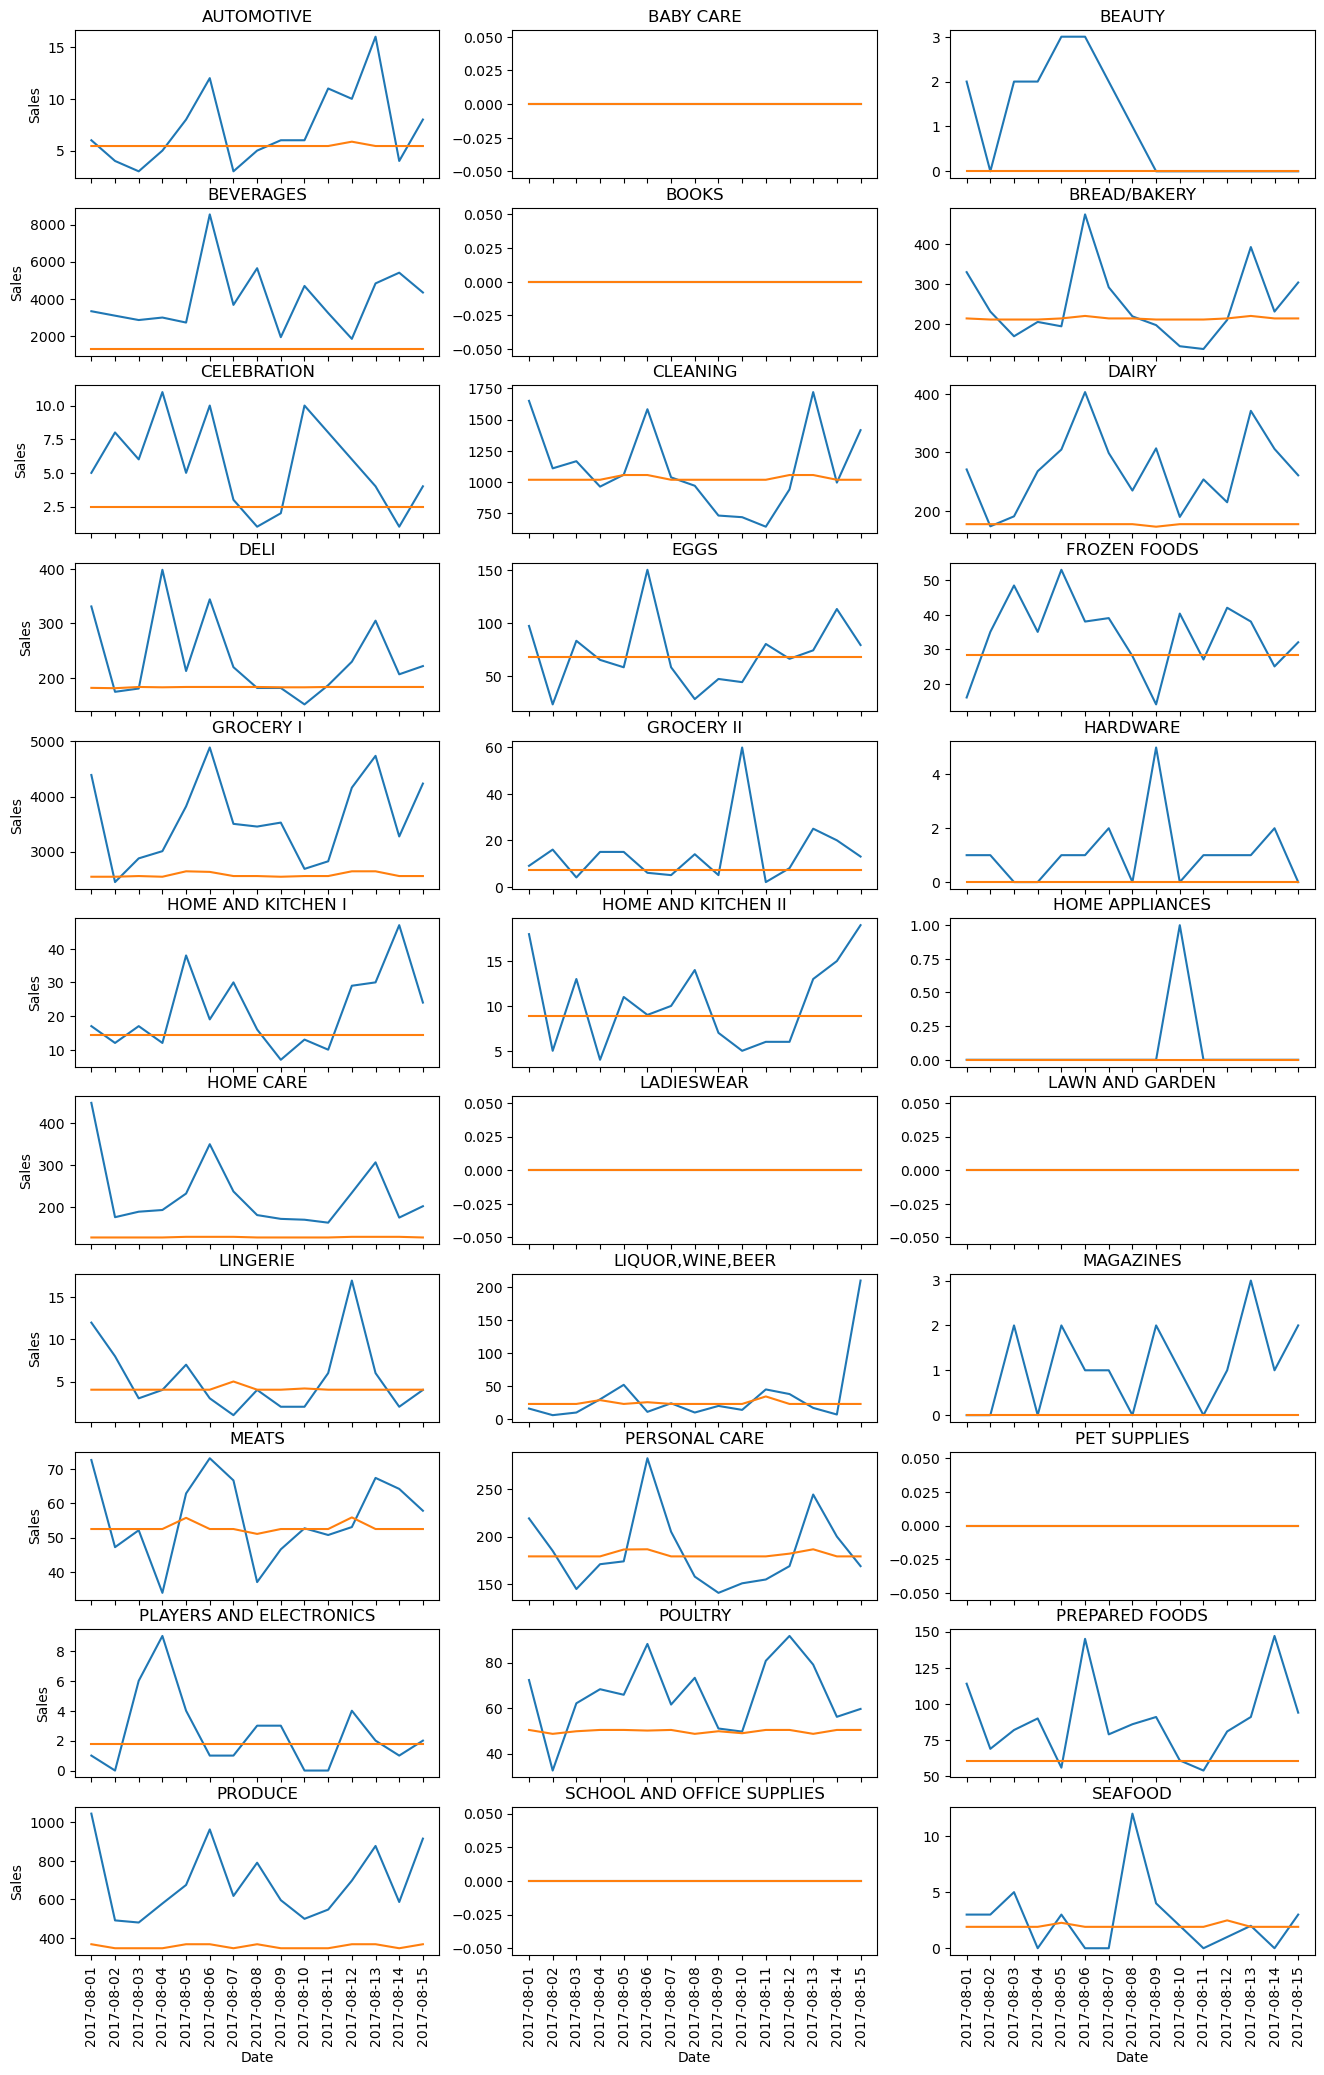

In [341]:
# Plot total sales and predicted sales
dates = pd.Series(pd.date_range(start='8/1/2017', end='8/15/2017',freq='D')).astype('str')

fig,ax = plt.subplots(nrows=11,ncols=3,figsize=(16,25),sharex=True)

for index,family in enumerate(families):
    # index//3 gives axis row number to plot
    # index%3 gives axis column number to plot
    ax[index//3,index%3].set_title(f'{family}')
    
    if (index//3)==10:
        ax[index//3,index%3].set_xlabel('Date')
        ax[index//3,index%3].set_xticks(ticks=dates,labels=dates, rotation=90)
    if (index%3)==0:
        ax[index//3,index%3].set_ylabel('Sales')
    
    ax[index//3,index%3].plot(dates,results[ tuned_combined['family']==family].groupby('date').sales.sum())
    ax[index//3,index%3].plot(dates,results[ tuned_combined['family']==family].groupby('date').predictions.sum())


# All stores (simultaneously)

In [ ]:
# Create training and validation sets


# Find index where we split training and validation sets
cutoff = train[ train.date == '2017-08-01' ].first_valid_index()

# Grabs the training data we want and splits into X and y
X_train = X.drop(columns=['transactions','sales'])
y_train = X['sales']
y_train_with_dates = X[['date','sales']]


# Define training sets from Jan 1, 2013 to Aug 1, 2017
# Define validation sets with Aug 1-15, 2017 data
X_tt = X_train.iloc[:cutoff]
X_val =  X_train.iloc[cutoff:]
y_tt = X['sales'].iloc[:cutoff]
y_val =  y_train.iloc[cutoff:]
y_val_with_dates = y_train_with_dates.iloc[cutoff:]

# Cast categorical variables as 'category' type for XGBoost.
X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
X_val[cat_attribs] = X_val[cat_attribs].astype('category')

In [ ]:
# Make and fit model
model = xgb.XGBRegressor(n_estimators=100, 
                         learning_rate=0.1, 
                         max_depth=9, 
                         enable_categorical=True)
model.fit(X_tt, y_tt)

# Make predictions
predictions = model.predict(X_val)
# Change and negative predictions to 0
predictions = np.clip(predictions, a_min=0, a_max=None)
y_val_with_dates['predictions'] = predictions

# Find RMSLE
print('Root Mean Squared Log Error',RMSLE(y_val_with_dates.sales, y_val_with_dates.predictions))


Root Mean Squared Log Error 0.566889365791511


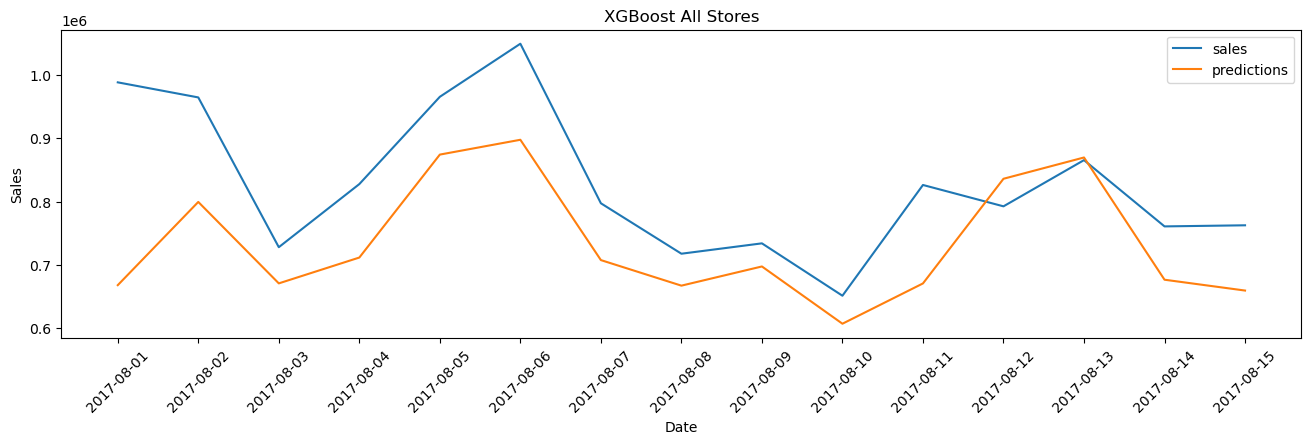

In [ ]:
# Plot total sales and predicted sales for the validation sets

fig = plt.figure(figsize=(16,4))

plt.title(f'XGBoost All Stores')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.plot(range(1,16),
        y_val_with_dates.groupby('date').sum().sales.values,
        label='sales')

plt.plot(range(1,16),
        y_val_with_dates.groupby('date').sum().predictions.values,
        label='predictions')

plt.xticks(ticks=np.arange(1,16),
            labels=y_val_with_dates.groupby('date').sum().index,
            rotation=45)    
plt.legend()
plt.show()

# All Stores (trained individually by store number and family)

In [76]:
# Create training and validation sets


# Find index where we split training and validation sets
cutoff = train[ train.date == '2017-08-01' ].first_valid_index()

# Partial DataFrame we will use to store predictions.
results = train[['id','date','store_nbr','family','sales']].iloc[cutoff:]

In [77]:
# Train XGBoost models on each store and product family

for store in stores:
    for family in families:
        
        # Picks data from one store and family, split into X and y
        X = train_data[store][family]
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['year','month','sales']]

        # Training sets up to Aug 2017
        X_tt = X_train[ (X_train['year']<=2017) & (X_train['month']<8)]
        y_tt = y_train[ (y_train['year']<=2017) & (y_train['month']<8)].drop(columns=['year','month'])
        # Validation sets from Aug 1-15, 2017
        X_val =  X_train[ (X_train['year']==2017) & (X_train['month']>=8)]
        y_val = y_train[ (y_train['year']==2017) & (y_train['month']>=8)].drop(columns=['year','month'])
        
        # Cast categorical variables for XGBoost.
        X_tt[cat_attribs] = X_tt[cat_attribs].astype('category')
        X_val[cat_attribs] = X_val[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         colsample_bytree=0.6,
                         subsample=1,
                         enable_categorical=True)
        model.fit(X_tt, y_tt)

        # Make predictions
        predictions = model.predict(X_val)
        predictions = np.clip(predictions, a_min=0, a_max=None)
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = results[ (results['store_nbr']==store) & (results['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        results.loc[indices_to_fill, 'predictions'] = predictions
        

In [79]:
results.head()

,id,date,store_nbr,family,sales,predictions
2728374,2974158,2017-08-01,1,AUTOMOTIVE,5.0,3.080547
2728375,2974159,2017-08-01,1,BABY CARE,0.0,0.000000
2728376,2974160,2017-08-01,1,BEAUTY,4.0,1.711641
2728377,2974161,2017-08-01,1,BEVERAGES,2627.0,2035.229614
2728378,2974162,2017-08-01,1,BOOKS,0.0,0.170629


In [84]:
# Create dates for validation set
dates = pd.Series(pd.date_range(start='8/1/2017', end='8/15/2017',freq='D')).astype('str')

# Compute total sales and predicted sales by date
sales = results.groupby('date')['sales'].sum()
predictions = results.groupby('date')['predictions'].sum()

# Compute RMSLE
print('RMSLE:',RMSLE(sales,predictions))

RMSLE: 0.14887486951615644


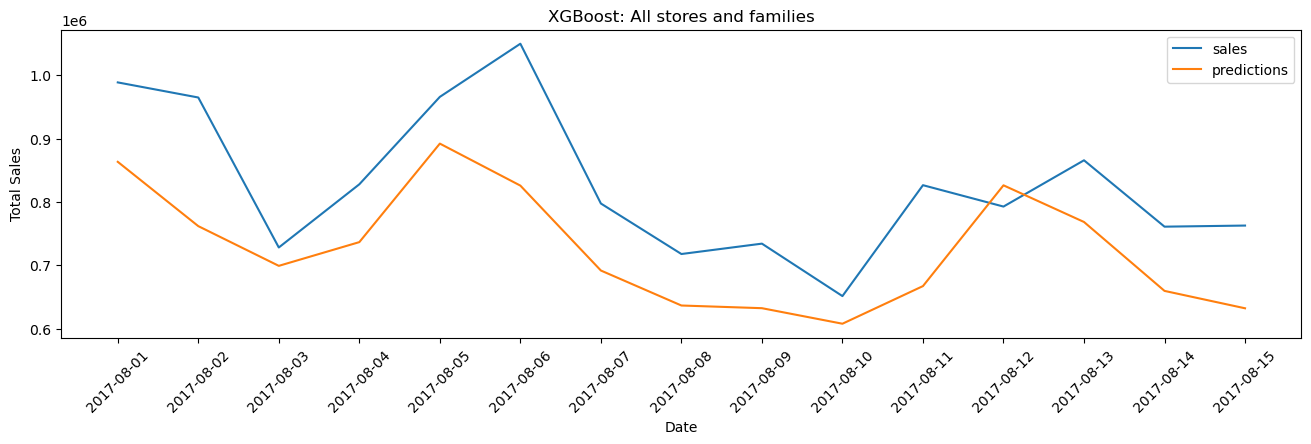

In [85]:
# Plot total sales and predicted sales

fig,ax = plt.subplots(figsize=(16,4))


ax.set_title('XGBoost: All stores and families')
ax.set_xlabel('Date')
ax.set_ylabel('Total Sales')

ax.plot(dates,sales,
        label='sales')

ax.plot(dates,predictions,
        label='predictions')

ax.set_xticks(ticks=dates,labels=dates, rotation=45)

ax.legend()
plt.show()

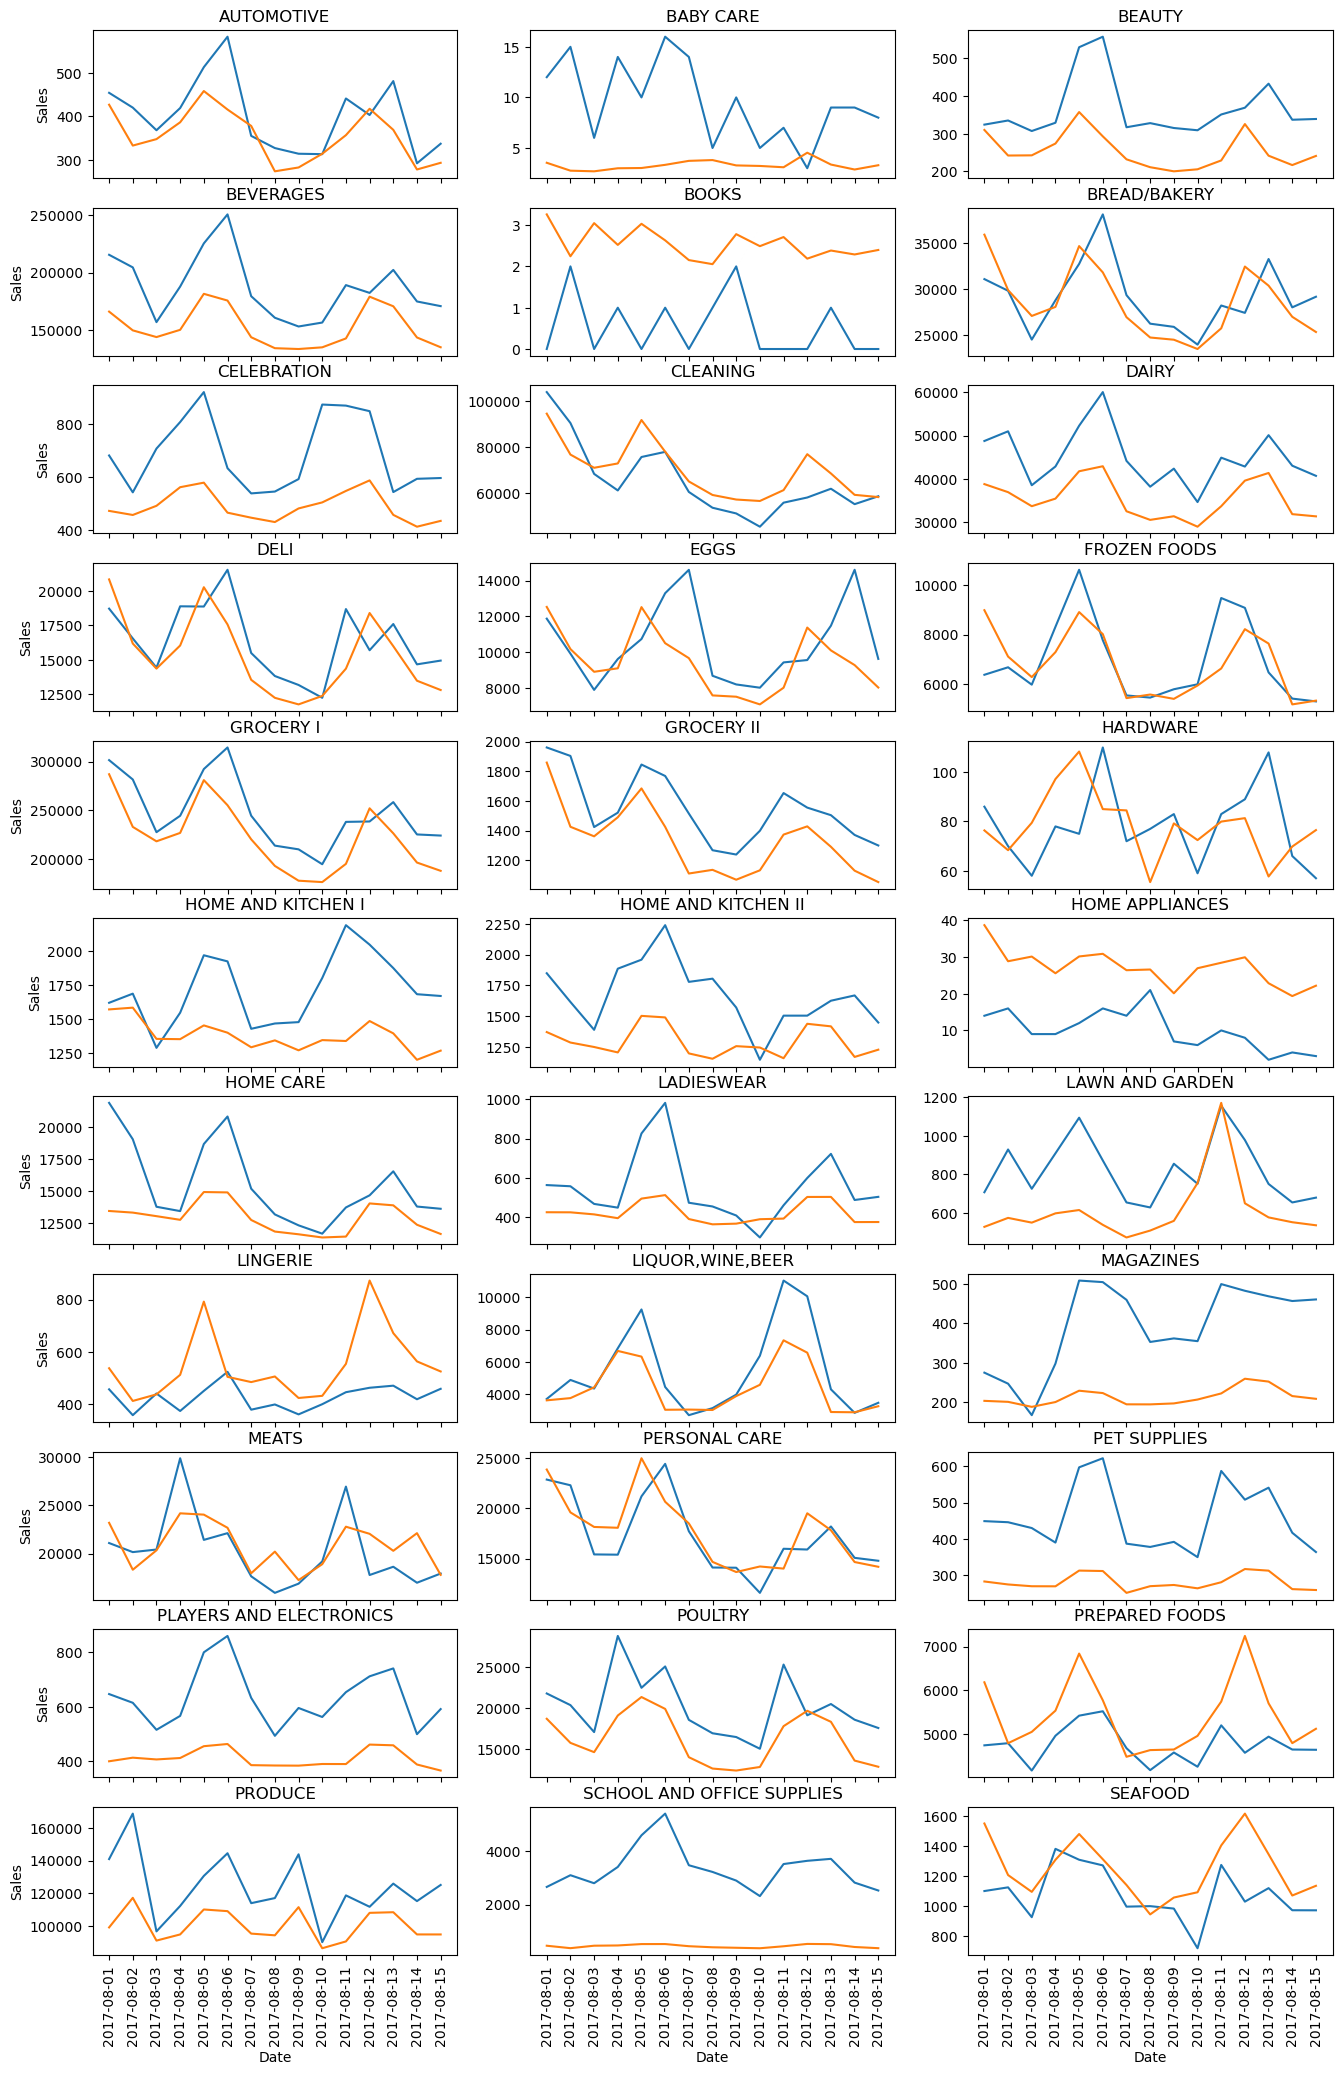

In [83]:
# Plot total sales and predicted sales
dates = pd.Series(pd.date_range(start='8/1/2017', end='8/15/2017',freq='D')).astype('str')

fig,ax = plt.subplots(nrows=11,ncols=3,figsize=(16,25),sharex=True)

for index,family in enumerate(families):
    # index//3 gives axis row number to plot
    # index%3 gives axis column number to plot
    ax[index//3,index%3].set_title(f'{family}')
    
    if (index//3)==10:
        ax[index//3,index%3].set_xlabel('Date')
        ax[index//3,index%3].set_xticks(ticks=dates,labels=dates, rotation=90)
    if (index%3)==0:
        ax[index//3,index%3].set_ylabel('Sales')
    
    ax[index//3,index%3].plot(dates,results[ results['family']==family].groupby('date').sales.sum())
    ax[index//3,index%3].plot(dates,results[ results['family']==family].groupby('date').predictions.sum())


# Prediction on Test Set

In [306]:
test_results = test[['id','date','store_nbr','family']]

In [327]:
# Train XGBoost models on each store and product family

for store in stores:
    for family in families:
        
        # Picks data from one store and family, split into X and y
        X = train_data[store][family]
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['sales']]

        X_test = test_data[store][family]

        # Cast categorical variables for XGBoost.
        X_train[cat_attribs] = X_train[cat_attribs].astype('category')
        X_test[cat_attribs] = X_test[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         colsample_bytree=0.6,
                         subsample=1,
                         enable_categorical=True)
        model.fit(X_train, y_train)

        # Make predictions
        predictions = model.predict(X_test)
        predictions = np.clip(predictions, a_min=0, a_max=None)
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = test_results[ (test_results['store_nbr']==store) & (test_results['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        test_results.loc[indices_to_fill, 'predictions'] = predictions
        

In [328]:
submission = test_results.rename(mapper={'predictions':'sales'},axis=1)
submission = submission.drop(columns=['date','store_nbr','family'])
submission

,id,sales
0,3000888,3.712035
1,3000889,0.000000
2,3000890,3.512727
3,3000891,2231.919678
4,3000892,0.049571
...,...,...
28507,3029395,390.895325
28508,3029396,94.419891
28509,3029397,975.222351
28510,3029398,18.719156


In [ ]:
# Run to create submission file
# submission.to_csv("submission.csv", index = False)

# Prediction with Fine Tuned Parameters

In [302]:
test_results_tuned = test[['id','date','store_nbr','family']]

In [ ]:
# Train XGBoost models on each store and product family

for store in stores:
    for family in families:
        
        # Picks data from one store and family, split into training X and y
        X = train_data[store][family]
        letter_type = X['type'].iloc[-1]
        
        X_train = X.drop(columns=['transactions','sales'])
        y_train = X[['sales']]
        
        X_test = test_data[store][family]

        # Cast categorical variables for XGBoost.
        X_train[cat_attribs] = X_train[cat_attribs].astype('category')
        X_test[cat_attribs] = X_test[cat_attribs].astype('category')
        
        # Make model and fit
        model = xgb.XGBRegressor(n_estimators=200, 
                         learning_rate=0.1, 
                         max_depth=3, 
                         colsample_bytree=0.6,
                         subsample=1,
                         enable_categorical=True)
        model.fit(X_train, y_train)

        model = xgb.XGBRegressor(colsample_by_tree = best_params[letter_type][index]['params']['colsample_bytree'],
                            learning_rate = best_params[letter_type][index]['params']['learning_rate'],
                            max_depth = best_params[letter_type][index]['params']['max_depth'],
                            n_estimators = best_params[letter_type][index]['params']['n_estimators'],
                            enable_categorical=True)

        # Make predictions
        predictions = model.predict(X_test)
        predictions = np.clip(predictions, a_min=0, a_max=None)
        # Find list of id's for rows where we want to add a prediction. Then add them.
        indices_to_fill = test_results_tuned[ (test_results_tuned['store_nbr']==store) & (test_results_tuned['family']==family) ]['id'].index
        
        # Merge predictions to results dataframe along the id's
        test_results_tuned.loc[indices_to_fill, 'predictions'] = predictions
        

In [323]:
submission_tuned = test_results_tuned.rename(mapper={'predictions':'sales'},axis=1)
submission_tuned = submission_tuned.drop(columns=['date','store_nbr','family'])
submission_tuned

,id,sales
0,3000888,3.099761
1,3000889,0.000000
2,3000890,2.312033
3,3000891,1733.804565
4,3000892,0.000000
...,...,...
28507,3029395,476.344391
28508,3029396,89.959419
28509,3029397,993.437317
28510,3029398,5.673428


In [326]:
# Run to create submission file
submission_tuned.to_csv("submission_tuned.csv", index = False)